In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=04e3c3c1ca247b1834bc6436404005ab88dabc8130760b30fa094feeab9c9362
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 156.1 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [3]:
cd /content/drive/My Drive/EIP/

/content/drive/My Drive/EIP


In [5]:
!ls

hvc_annotations.csv  hvc_data.zip  resized


In [6]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16, InceptionResNetV2, ResNet50V2
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [7]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [8]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
from keras.preprocessing.image import ImageDataGenerator

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation=augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        if self.augmentation is not None:
          image = self.augmentation.flow(image, shuffle=False).next()        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


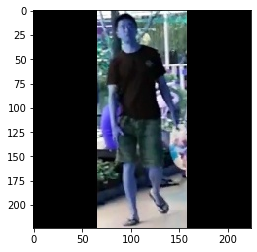

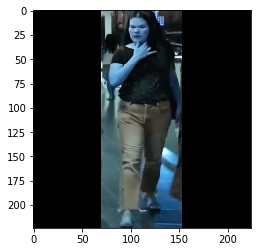

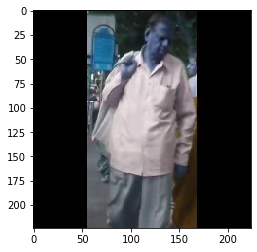

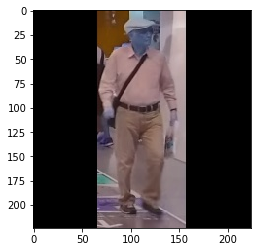

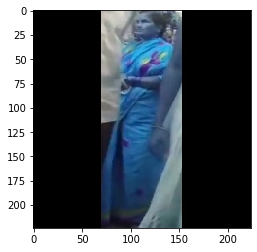

In [11]:
for i in range (0,5):
  items=one_hot_df.iloc[slice(0, 5, None)]
  image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
  plt.figure()
  plt.imshow(image[i])

In [12]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [13]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
2372,resized/2373.jpg,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
8930,resized/8931.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
10963,resized/10965.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
76,resized/77.jpg,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0
9928,resized/9929.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, 
                                augmentation=ImageDataGenerator(
                                    horizontal_flip=True, 
                                    preprocessing_function=get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False),
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2                                    
                                    ))


# # fit the data augmentation
# train_gen.fit(train_df)

# # setup generator
# train_generator = train_gen.flow_from_directory(
#         train_data_dir,
#         target_size=(img_height, img_width),
#         batch_size=batch_size,
#         class_mode='categorical')



valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [15]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [16]:
backbone = InceptionResNetV2(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)


neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.1)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 90:
        lr *= 0.5e-3
    elif epoch > 75:
        lr *= 1e-3
    elif epoch > 50:
        lr *= 1e-2
    elif epoch > 25:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [20]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",

}
loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr=0.001, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [ lr_reducer, lr_scheduler]

In [21]:
history=model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=9,
    epochs=100,
    verbose=1,
    callbacks=callbacks
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
Learning rate:  0.001

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
360/360 [==============================] - 345s 959ms/step - loss: 8.1017 - gender_output_loss: 0.6996 - image_quality_output_loss: 1.0116 - age_output_loss: 1.4606 - weight_output_loss: 1.0316 - bag_output_loss: 0.9490 - footwear_output_loss: 1.0393 - pose_output_loss: 0.9548 - emotion_output_loss: 0.9551 - gender_output_acc: 0.5456 - image_quality_output_acc: 0.5342 - age_output_acc: 0.3803 - weight_output_acc: 0.6240 - bag_output_acc: 0.5452 - footwear_output_acc: 0.4782 - pose_output_acc: 0.6082 - emotion_output_acc: 0.7033 - val_loss: 7.7502 - val_gender_output_loss: 0.6869 - val_image_quality_output_loss: 0.9648 - val_age_output_loss: 1.4138 - val_weight_output_loss: 0.9743 - val_bag_output_loss: 0.9156 - val_footwear_output_loss: 0.9824 - val_pose_output_loss: 0.9209 - val_emotion_out

In [22]:
results = model.evaluate_generator(valid_gen, verbose =1)

31/31 [==============================] - 16s 523ms/step


In [23]:
results = model.evaluate_generator(valid_gen,verbose = 1)
accuracy = {}
loss = {}
for k,v in zip(model.metrics_names,results):
  if k.endswith('acc'):
    accuracy[k] = round(v * 100.0,3)
  else:
    loss[k] = v
accuracy

31/31 [==============================] - 13s 421ms/step


{'age_output_acc': 40.474,
 'bag_output_acc': 62.248,
 'emotion_output_acc': 72.228,
 'footwear_output_acc': 62.802,
 'gender_output_acc': 83.619,
 'image_quality_output_acc': 58.72,
 'pose_output_acc': 79.133,
 'weight_output_acc': 64.264}

In [24]:
dict(zip(model.metrics_names, results))

{'age_output_acc': 0.40473790322580644,
 'age_output_loss': 1.3601134477123138,
 'bag_output_acc': 0.6224798387096774,
 'bag_output_loss': 0.8335875599615036,
 'emotion_output_acc': 0.7222782258064516,
 'emotion_output_loss': 0.856159302496141,
 'footwear_output_acc': 0.6280241935483871,
 'footwear_output_loss': 0.796331117230077,
 'gender_output_acc': 0.8361895161290323,
 'gender_output_loss': 0.36596756885128634,
 'image_quality_output_acc': 0.5871975806451613,
 'image_quality_output_loss': 0.8921160198027088,
 'loss': 6.579577522893106,
 'pose_output_acc': 0.7913306451612904,
 'pose_output_loss': 0.5311573234296614,
 'weight_output_acc': 0.6426411290322581,
 'weight_output_loss': 0.9441452468595197}

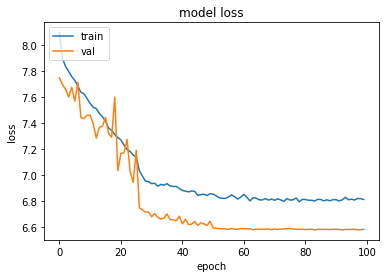

In [25]:
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
# from keras.utils import plot_model
# plot_model(model, show_shapes=True  ,to_file='model.png')